# TPLC 模型消融实验 (Notebook 版)

这个 Notebook 用于运行 TPLC 模型的消融实验，验证各个改进模块（RevIN, Inception Block, Decomposition, Stacked）的有效性。

## 实验配置列表
- **baseline**: 原始 TPLC 模型
- **+revin**: 添加 RevIN 归一化
- **+inception**: 替换卷积层为 Inception Block
- **+decomp**: 添加季节-趋势分解
- **+stacked**: 使用多层堆叠结构
- **full**: 完整改进模型

## 使用说明
1. 运行前面的“配置与模型定义”单元格初始化环境。
2. 在“运行实验”部分选择要运行的配置。
3. 查看输出的指标对比表格和可视化图表。

In [1]:
# 1. 导入依赖与环境设置
%load_ext autoreload
%autoreload 2

import sys
import time
import json
from pathlib import Path
from datetime import datetime
from dataclasses import dataclass, asdict, field
from typing import Any, Dict, List, Optional

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 添加项目路径 (假设当前在 ablation 目录)
current_dir = Path.cwd()
tplc_net_dir = current_dir.parent
if str(tplc_net_dir) not in sys.path:
    sys.path.insert(0, str(tplc_net_dir))

print(f"工作目录: {current_dir}")
print(f"项目路径: {tplc_net_dir}")

# 导入 tplc_algo
try:
    from tplc_algo.pipeline import make_loaders, prepare_greenhouse_datasets
    from tplc_algo.train import Trainer, TrainConfig
    from tplc_algo.utils import seed_everything
    from tplc_algo.exp_utils import create_run_dir, save_config_json, save_metrics_json, save_history_csv
    print("tplc_algo 导入成功")
except ImportError as e:
    print(f"[Error] 无法导入 tplc_algo: {e}")
    print("请确保 notebook 在 scheme_1/TPLC_Net/ablation 目录下运行")

# 导入消融模块 (当前目录)
try:
    from revin import RevIN
    from inception import Inception_Block_V1
    from decomposition import DFT_series_decomp, series_decomp
    from stacked_block import TPLCBlock
    print("消融模块导入成功")
except ImportError as e:
    print(f"[Error] 无法导入消融模块: {e}")

工作目录: d:\degree_code_scheme_1\scheme_1\TPLC_Net\ablation
项目路径: d:\degree_code_scheme_1\scheme_1\TPLC_Net
tplc_algo 导入成功
消融模块导入成功


In [2]:
# 2. 定义配置类

@dataclass
class AblationConfig:
    """消融实验配置。"""
    # 实验名称
    name: str = "baseline"
    
    # 模型配置
    input_dim: int = 10
    target_dim: int = 10
    seq_len: int = 96
    pred_len: int = 24
    hidden_dim: int = 64
    num_scales: int = 2
    top_k_periods: int = 3
    dropout: float = 0.1
    
    # 消融开关
    use_revin: bool = False           # RevIN 归一化
    use_inception: bool = False       # Inception Block（替代 DepthwiseSeparable）
    use_decomp: bool = False          # 季节-趋势分解
    decomp_method: str = "dft"        # 分解方法: "dft" 或 "moving_avg"
    decomp_kernel: int = 25           # Moving Avg 核大小
    use_stacked: bool = False         # 多层堆叠
    e_layers: int = 2                 # 堆叠层数
    
    # 训练配置
    batch_size: int = 32
    epochs: int = 15      # 由于是演示，默认轮数设小一点
    lr: float = 1e-3
    weight_decay: float = 0.0
    early_stop_patience: int = 5
    
    # 数据配置
    dataset_type: str = "single_file"
    # 请确认此路径是否存在，如果不同请修改
    dataset_path: str = r"D:\学位会\数据集\温室环境数据(4万条)\GreenhouseClimate1.csv"
    
    # 其他
    seed: int = 42
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

# 预定义配置字典
ABLATION_CONFIGS = {
    "baseline": AblationConfig(name="baseline"),
    "+revin": AblationConfig(name="+revin", use_revin=True),
    "+inception": AblationConfig(name="+inception", use_inception=True),
    "+decomp": AblationConfig(name="+decomp", use_decomp=True),
    "+stacked": AblationConfig(name="+stacked", use_stacked=True, e_layers=2),
    "+revin+inception": AblationConfig(name="+revin+inception", use_revin=True, use_inception=True),
    "full": AblationConfig(
        name="full",
        use_revin=True,
        use_inception=True,
        use_decomp=True,
        use_stacked=True,
        e_layers=2,
    ),
}

In [3]:
# 3. 定义消融模型

class TPLCNet_Ablation(nn.Module):
    """TPLC 消融实验模型。"""
    
    def __init__(self, cfg: AblationConfig) -> None:
        super().__init__()
        self.cfg = cfg
        
        # 1. RevIN 归一化
        self.revin = None
        if cfg.use_revin:
            self.revin = RevIN(num_features=cfg.input_dim, affine=True)
        
        # 2. 季节-趋势分解
        self.decomp = None
        if cfg.use_decomp:
            if cfg.decomp_method == "dft":
                self.decomp = DFT_series_decomp(top_k=cfg.top_k_periods)
            else:
                self.decomp = series_decomp(kernel_size=cfg.decomp_kernel)
        
        # 3. Embedding 层
        self.embedding = nn.Sequential(
            nn.Linear(cfg.input_dim, cfg.hidden_dim),
            nn.GELU(),
            nn.Dropout(cfg.dropout),
        )
        
        # 4. 主干网络
        # 无论是否 stacked，都使用 ModuleList 方便统一管理
        num_layers = cfg.e_layers if cfg.use_stacked else 1
        
        self.blocks = nn.ModuleList([
            TPLCBlock(
                d_model=cfg.hidden_dim,
                seq_len=cfg.seq_len,
                pred_len=cfg.pred_len,
                top_k=cfg.top_k_periods,
                num_scales=cfg.num_scales,
                use_inception=cfg.use_inception,
                dropout=cfg.dropout,
            )
            for _ in range(num_layers)
        ])
        self.layer_norm = nn.LayerNorm(cfg.hidden_dim)
        
        # 5. 预测投影
        self.projection = nn.Linear(cfg.hidden_dim, cfg.target_dim)
        
        # 6. 时间维度投影（seq_len -> pred_len）
        self.time_proj = nn.Linear(cfg.seq_len, cfg.pred_len)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # 1. RevIN 归一化
        if self.revin is not None:
            x = self.revin(x, mode='norm')
        
        # 2. 季节-趋势分解
        x_season, x_trend = None, None
        if self.decomp is not None:
            x_season, x_trend = self.decomp(x)
            x_main = x_season
        else:
            x_main = x
            x_trend = torch.zeros_like(x)
        
        # 3. Embedding
        enc_out = self.embedding(x_main)  # [B, seq_len, hidden_dim]
        
        # 4. 主干网络
        for block in self.blocks:
            enc_out = self.layer_norm(block(enc_out))
        
        # 5. 时间投影
        enc_out = enc_out.transpose(1, 2)  # [B, hidden, seq]
        enc_out = self.time_proj(enc_out)
        enc_out = enc_out.transpose(1, 2)  # [B, pred, hidden]
        
        # 6. 预测投影
        y = self.projection(enc_out)
        
        # 7. 加回趋势
        if self.decomp is not None and x_trend is not None:
            trend_proj = x_trend[:, -self.cfg.pred_len:, :self.cfg.target_dim]
            if trend_proj.shape[1] < self.cfg.pred_len:
                trend_proj = F.pad(trend_proj, (0, 0, self.cfg.pred_len - trend_proj.shape[1], 0))
            y = y + trend_proj
        
        # 8. RevIN 反归一化
        if self.revin is not None:
            y = self.revin(y, mode='denorm')
        
        return y

In [4]:
# 4. 定义实验运行器

class NotebookAblationRunner:
    def __init__(self, cfg: AblationConfig):
        self.cfg = cfg
        self.results_dir = Path.cwd() / "results"
        self.results_dir.mkdir(exist_ok=True)
        
    def load_data(self):
        print(f"\n{'='*40}")
        print(f"加载数据: {self.cfg.dataset_path}")
        
        dataset_root = Path(self.cfg.dataset_path).parent
        selected_features = [
            'Tair', 'Rhair', 'CO2air', 'Tot_PAR', 'PipeGrow',
            'VentLee', 'Ventwind', 'HumDef', 'water_sup', 'EnScr'
        ]
        
        prepared = prepare_greenhouse_datasets(
            dataset_root=dataset_root,
            team='.',
            seq_len=self.cfg.seq_len,
            pred_len=self.cfg.pred_len,
            stride=1,
            base_table=Path(self.cfg.dataset_path).name,
            extra_tables=(),
            selected_features=selected_features,
            missing_rate_threshold=0.7,
            drop_constant=True,
            protect_target_cols=True,
        )
        
        self.feature_cols = prepared.feature_cols
        self.target_cols = prepared.target_cols
        
        # 更新配置维度
        self.cfg.input_dim = len(self.feature_cols)
        self.cfg.target_dim = len(self.target_cols)
        
        train_loader, val_loader, test_loader = make_loaders(
            prepared, batch_size=self.cfg.batch_size
        )
        
        print(f"输入维度: {self.cfg.input_dim}, 输出维度: {self.cfg.target_dim}")
        print(f"Train/Val/Test batches: {len(train_loader)} / {len(val_loader)} / {len(test_loader)}")
        return train_loader, val_loader, test_loader
    
    def run(self):
        seed_everything(self.cfg.seed)
        
        # 加载数据
        train_loader, val_loader, test_loader = self.load_data()
        
        # 构建模型
        print(f"\n构建模型: {self.cfg.name}")
        print(f"RevIN={self.cfg.use_revin}, Inception={self.cfg.use_inception}, "
              f"Decomp={self.cfg.use_decomp}, Stacked={self.cfg.use_stacked}")
        
        model = TPLCNet_Ablation(self.cfg)
        
        # 训练配置
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        run_dir = self.results_dir / f"{self.cfg.name}_{timestamp}"
        run_dir.mkdir(parents=True, exist_ok=True)
        ckpt_path = run_dir / "checkpoints" / "best.pt"
        
        trainer = Trainer(
            model=model,
            cfg=TrainConfig(
                epochs=self.cfg.epochs,
                lr=self.cfg.lr,
                weight_decay=self.cfg.weight_decay,
                device=self.cfg.device,
                ckpt_path=ckpt_path,
                use_amp=(self.cfg.device == 'cuda'),
                early_stop_patience=self.cfg.early_stop_patience,
                show_progress=True,
            )
        )
        
        print("开始训练...")
        start_time = time.time()
        history = trainer.fit(train_loader, val_loader=val_loader)
        train_time = time.time() - start_time
        
        print("\n评估测试集...")
        metrics = trainer.evaluate(test_loader)
        metrics['train_time'] = train_time
        metrics['config'] = self.cfg.name
        
        # 补全缺失的指标
        if 'mse' not in metrics and 'loss' in metrics:
             metrics['mse'] = metrics['loss']
        elif 'mse' not in metrics and 'rmse' in metrics:
             metrics['mse'] = metrics['rmse'] ** 2
             
        if 'mape' not in metrics:
             metrics['mape'] = float('nan')
        
        print(f"结果: MAE={metrics['mae']:.4f}, MSE={metrics['mse']:.4f}")
        
        # 保存
        save_config_json(run_dir, asdict(self.cfg))
        save_metrics_json(run_dir, metrics)
        save_history_csv(run_dir, history)
        
        return metrics, history

In [5]:
# 5. 运行基线模型 (Baseline)
# 建议先跑一下基线，确保环境正常

cfg_baseline = ABLATION_CONFIGS['baseline']
cfg_baseline.epochs = 5  # 演示用，减少epoch

runner = NotebookAblationRunner(cfg_baseline)
metrics_base, history_base = runner.run()


加载数据: D:\学位会\数据集\温室环境数据(4万条)\GreenhouseClimate1.csv
使用 selected_features: 10 个特征
输入维度: 10, 输出维度: 3
Train/Val/Test batches: 1042 / 146 / 296

构建模型: baseline
RevIN=False, Inception=False, Decomp=False, Stacked=False
开始训练...


train (epoch): 100%|##########| 5/5 [00:38<00:00,  7.70s/epoch, train=0.1194, val=0.7344]



评估测试集...


结果: MAE=0.6412, MSE=0.6852


In [6]:
# 6. 运行所有消融配置并对比

# 选择要运行的配置列表
configs_to_run = ['baseline', '+revin', '+inception', '+decomp', 'full']

all_results = []

for name in configs_to_run:
    print(f"\n{'#'*60}\nRunning: {name}\n{'#'*60}")
    try:
        cfg = ABLATION_CONFIGS[name]
        cfg.epochs = 10  # 统一训练轮数
        
        runner = NotebookAblationRunner(cfg)
        metrics, _ = runner.run()
        all_results.append(metrics)
    except Exception as e:
        print(f"[Error] {name} 运行失败: {e}")


############################################################
Running: baseline
############################################################

加载数据: D:\学位会\数据集\温室环境数据(4万条)\GreenhouseClimate1.csv
使用 selected_features: 10 个特征
输入维度: 10, 输出维度: 3
Train/Val/Test batches: 1042 / 146 / 296

构建模型: baseline
RevIN=False, Inception=False, Decomp=False, Stacked=False
开始训练...


train (epoch): 100%|##########| 10/10 [01:15<00:00,  7.58s/epoch, train=0.1090, val=0.8014]



评估测试集...


结果: MAE=0.6639, MSE=0.7369

############################################################
Running: +revin
############################################################

加载数据: D:\学位会\数据集\温室环境数据(4万条)\GreenhouseClimate1.csv
使用 selected_features: 10 个特征
输入维度: 10, 输出维度: 3
Train/Val/Test batches: 1042 / 146 / 296

构建模型: +revin
RevIN=True, Inception=False, Decomp=False, Stacked=False
开始训练...


train (epoch): 100%|##########| 10/10 [01:23<00:00,  8.32s/epoch, train=0.6199, val=3.1519]



评估测试集...


结果: MAE=1.5071, MSE=3.9850

############################################################
Running: +inception
############################################################

加载数据: D:\学位会\数据集\温室环境数据(4万条)\GreenhouseClimate1.csv
使用 selected_features: 10 个特征
输入维度: 10, 输出维度: 3
Train/Val/Test batches: 1042 / 146 / 296

构建模型: +inception
RevIN=False, Inception=True, Decomp=False, Stacked=False
[Error] +inception 运行失败: attempted relative import with no known parent package

############################################################
Running: +decomp
############################################################

加载数据: D:\学位会\数据集\温室环境数据(4万条)\GreenhouseClimate1.csv
使用 selected_features: 10 个特征
输入维度: 10, 输出维度: 3
Train/Val/Test batches: 1042 / 146 / 296

构建模型: +decomp
RevIN=False, Inception=False, Decomp=True, Stacked=False
开始训练...


train (epoch): 100%|##########| 10/10 [01:23<00:00,  8.36s/epoch, train=0.2819, val=1.1888]



评估测试集...


结果: MAE=1.1353, MSE=2.3797

############################################################
Running: full
############################################################

加载数据: D:\学位会\数据集\温室环境数据(4万条)\GreenhouseClimate1.csv
使用 selected_features: 10 个特征
输入维度: 10, 输出维度: 3
Train/Val/Test batches: 1042 / 146 / 296

构建模型: full
RevIN=True, Inception=True, Decomp=True, Stacked=True
[Error] full 运行失败: attempted relative import with no known parent package



消融实验结果汇总:


,config,mae,mse,rmse,mape,train_time
0,baseline,0.663868,0.736921,0.819251,NaN,75.804896
2,+decomp,1.135309,2.379723,1.371830,NaN,83.601401
1,+revin,1.507096,3.985019,1.848299,NaN,83.221482


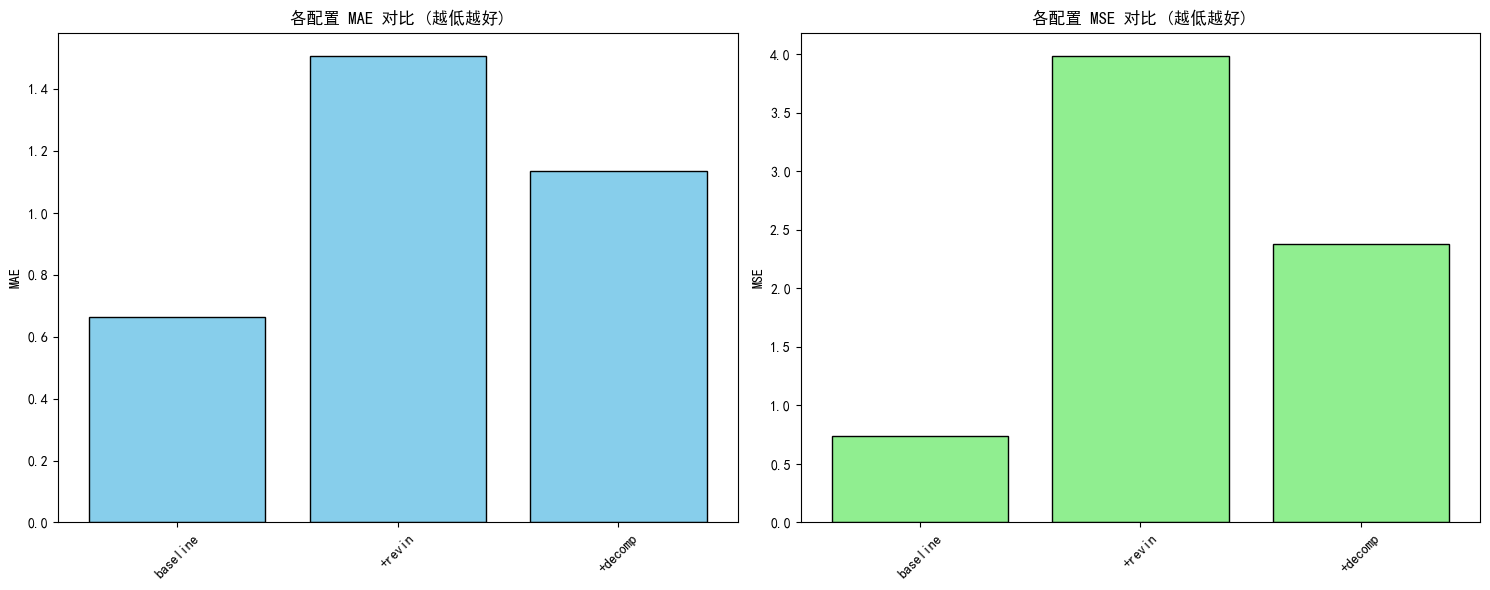

In [7]:
# 7. 结果可视化：对比图表

if all_results:
    df_res = pd.DataFrame(all_results)
    
    # 打印表格
    print("\n消融实验结果汇总:")
    display(df_res[['config', 'mae', 'mse', 'rmse', 'mape', 'train_time']].sort_values('mae'))
    
    # 绘图
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # MAE 对比
    axes[0].bar(df_res['config'], df_res['mae'], color='skyblue', edgecolor='black')
    axes[0].set_title('各配置 MAE 对比 (越低越好)')
    axes[0].set_ylabel('MAE')
    axes[0].tick_params(axis='x', rotation=45)
    
    # MSE 对比
    axes[1].bar(df_res['config'], df_res['mse'], color='lightgreen', edgecolor='black')
    axes[1].set_title('各配置 MSE 对比 (越低越好)')
    axes[1].set_ylabel('MSE')
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
else:
    print("没有可展示的结果，请先运行第 6 步")